Accuracy: 0.98


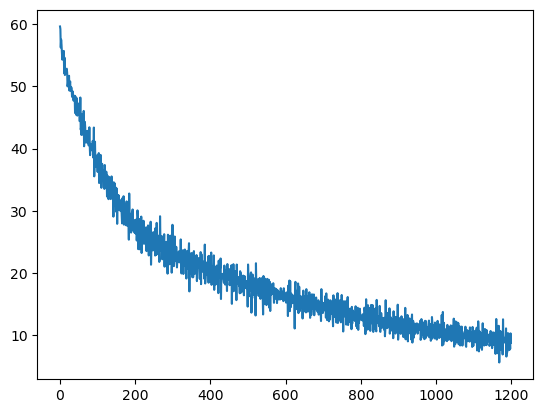

In [1]:
import random
import numpy as np

INPUT_DIM = 4
OUT_DIM = 3
H_DIM = 10

def relu(t):
    return np.maximum(t, 0)

def softmax(t):
    out = np.exp(t)
    return out / np.sum(out)

def softmax_batch(t):
    out = np.exp(t)
    return out / np.sum(out, axis=1, keepdims=True)

def sparse_cross_entropy(z, y):
    return -np.log(z[0, y])

def sparse_cross_entropy_batch(z, y):
    return -np.log(np.array([z[j, y[j]] for j in range(len(y))]))

def to_full(y, num_classes):
    y_full = np.zeros((1, num_classes))
    y_full[0, y] = 1
    return y_full

def to_full_batch(y, num_classes):
    y_full = np.zeros((len(y), num_classes))
    for j, yj in enumerate(y):
        y_full[j, yj] = 1
    return y_full

def relu_deriv(t):
    return (t >= 0).astype(float)

from sklearn import datasets
iris = datasets.load_iris()
dataset = [(iris.data[i][None, ...], iris.target[i]) for i in range(len(iris.target))]

W1 = np.random.rand(INPUT_DIM, H_DIM)
b1 = np.random.rand(1, H_DIM)
W2 = np.random.rand(H_DIM, OUT_DIM)
b2 = np.random.rand(1, OUT_DIM)

W1 = (W1 - 0.5) * 2 * np.sqrt(1/INPUT_DIM)
b1 = (b1 - 0.5) * 2 * np.sqrt(1/INPUT_DIM)
W2 = (W2 - 0.5) * 2 * np.sqrt(1/H_DIM)
b2 = (b2 - 0.5) * 2 * np.sqrt(1/H_DIM)

ALPHA = 0.0002
NUM_EPOCHS = 400
BATCH_SIZE = 50

loss_arr = []

for ep in range(NUM_EPOCHS):
    random.shuffle(dataset)
    for i in range(len(dataset) // BATCH_SIZE):

        batch_x, batch_y = zip(*dataset[i*BATCH_SIZE : i*BATCH_SIZE+BATCH_SIZE])
        x = np.concatenate(batch_x, axis=0)
        y = np.array(batch_y)

        # Forward
        t1 = x @ W1 + b1
        h1 = relu(t1)
        t2 = h1 @ W2 + b2
        z = softmax_batch(t2)
        E = np.sum(sparse_cross_entropy_batch(z, y))

        # Backward
        y_full = to_full_batch(y, OUT_DIM)
        dE_dt2 = z - y_full
        dE_dW2 = h1.T @ dE_dt2
        dE_db2 = np.sum(dE_dt2, axis=0, keepdims=True)
        dE_dh1 = dE_dt2 @ W2.T
        dE_dt1 = dE_dh1 * relu_deriv(t1)
        dE_dW1 = x.T @ dE_dt1
        dE_db1 = np.sum(dE_dt1, axis=0, keepdims=True)

        # Update
        W1 = W1 - ALPHA * dE_dW1
        b1 = b1 - ALPHA * dE_db1
        W2 = W2 - ALPHA * dE_dW2
        b2 = b2 - ALPHA * dE_db2

        loss_arr.append(E)

def predict(x):
    t1 = x @ W1 + b1
    h1 = relu(t1)
    t2 = h1 @ W2 + b2
    z = softmax_batch(t2)
    return z

def calc_accuracy():
    correct = 0
    for x, y in dataset:
        z = predict(x)
        y_pred = np.argmax(z)
        if y_pred == y:
            correct += 1
    acc = correct / len(dataset)
    return acc

accuracy = calc_accuracy()
print("Accuracy:", accuracy)

import matplotlib.pyplot as plt
plt.plot(loss_arr)
plt.show()